In [1]:
import sys, os
# sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_softplus")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from collections import defaultdict

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from lib.simdata_i3 import I3SimHandler


from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.gupta_network_eqx_4comp import get_network_eval_v_fn
from lib.gupta import c_multi_gupta_mpe_prob_midpoint2
from lib.gupta import c_multi_gupta_spe_prob
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

import time

from collections import defaultdict
from collections import defaultdict

2025-10-02 10:20:05.756618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dtype = jnp.float64
eval_network_v = get_network_eval_v_fn(bpath='/mnt/scratch/baburish/TPN-training/gupta_mixture_jax/test_no_penalties_tree_start_epoch_35.eqx', dtype=dtype, n_hidden=96)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype) 

2025-10-02 10:20:09.145832: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [22]:
def make_event_plot(event_start, event_end, event_id=22644):
    global eval_network_doms_and_track
    if event_id == 22644:
        bp = '/mnt/research/IceCube/Gupta-Reco/22644/tfrecords/ftr/'
    if event_id == 22645:
        bp = '/mnt/research/IceCube/Gupta-Reco/22645/tfrecords/ftr/'
    if event_id == 22646:
        bp = '/mnt/research/IceCube/Gupta-Reco/22646/tfrecords/ftr/'
    if event_id == 21217:
        bp = '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/'

    # sim_handler = I3SimHandler(os.path.join(bp, f'meta_ds_{event_id}_from_{event_start}_to_{event_end}_10_to_100TeV.ftr'),
    #                           os.path.join(bp, f'pulses_ds_{event_id}_from_{event_start}_to_{event_end}_10_to_100TeV.ftr'),
    #                           '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/data/icecube/detector_geometry.csv')
    sim_handler = I3SimHandler(os.path.join(bp, f'/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/meta_ds_event_10145_from_0_to_10_1st_pulse.ftr'),
                              os.path.join(bp, f'/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/pulses_ds_event_10145_from_0_to_10_1st_pulse.ftr'),
                              '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/data/icecube/detector_geometry.csv')
    # pdf = PdfPages(f"pdfs_{event_id}.pdf")

    # get data for this event
    meta, pulses = sim_handler.get_event_data(0)
    print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

    track_time = meta['muon_time']
    track_pos = [meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']]
    track_dir = [meta['muon_zenith'], meta['muon_azimuth']]

    # Get dom locations, first hit times, and total charges (for each dom).
    event_data_orig = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

    # Remove early pulses.
    sim_handler.replace_early_pulse(event_data, pulses)

    hit_sid = event_data['sensor_id'].values
    hit_first_t_orig = event_data_orig['time'].values - track_time
    hit_first_t = event_data['time'].values - track_time
    hit_x = event_data['x'].values
    hit_y = event_data['y'].values
    hit_z = event_data['z'].values

    # now collect all hits for this dom
    hit_t = []
    hit_q = []

    for s_id in hit_sid:
        idx = pulses['sensor_id'] == s_id
        pulses_this_dom = pulses[idx]
        hit_t.append(pulses_this_dom['time'].values - track_time)
        hit_q.append(pulses_this_dom['charge'].values)

    dom_data = defaultdict(lambda: defaultdict(float))
    dom_data_pulses = defaultdict(lambda: defaultdict(list))

    for i in range(len(hit_x)):
        # loop over doms and repackage data
        x = hit_x[i]
        y = hit_y[i]
        z = hit_z[i]

        sid = hit_sid[i]
        dom_data[(x,y,z)]['first_hit_time'] = hit_first_t[i]
        dom_data[(x,y,z)]['first_hit_time_orig'] = hit_first_t_orig[i]
        dom_data[(x,y,z)]['sensor_id'] = sid

        for j in range(len(hit_t[i])):
            # loop over pulses:
            dom_data_pulses[(x,y,z)]['q'].append(hit_q[i][j])
            dom_data_pulses[(x,y,z)]['t'].append(hit_t[i][j])

    for key in dom_data.keys():
        # get qtot for each dom
        dom_data[key]['q_tot'] = np.sum(dom_data_pulses[key]['q'])

    sorting = 'charge'

    dom_pos = []
    for key in dom_data.keys():
        dom_pos.append(jnp.array(key).reshape((1,3)))

    dom_pos = jnp.concatenate(dom_pos, axis=0)
    track_pos = jnp.array(track_pos)
    track_dir = jnp.array(track_dir)

    # evaluate network for these doms
    # notice that all true track vertex and directions are the same. So we use the first one.
    logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, track_pos, track_dir)
    mix_probs = jax.nn.softmax(logits)

    # get also the other DOM info
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)

    geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
                cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                             track_pos,
                                             track_dir_xyz)

    # convert first_hit_times to delay_times by subtracting geo_times
    # and add more dom data to dom_data dict

    network_data = defaultdict(lambda: defaultdict(lambda: np.ndarray))
    for i in range(len(dom_pos)):
        pos = tuple(np.array(dom_pos[i]))
        gt = geo_time[i]

        dom_data[pos]['first_hit_time'] -= float(gt)
        dom_data[pos]['first_hit_time_orig'] -= float(gt)

        dom_data_pulses[pos]['t'] = np.array(dom_data_pulses[pos]['t']) - float(gt)

        dom_data[pos]['closest_approach_dist'] = closest_approach_dist[i]
        dom_data[pos]['closest_approach_rho'] = closest_approach_rho[i]
        dom_data[pos]['closest_approach_z'] = closest_approach_z[i]

        network_data[pos]['mix_probs'] = np.array(mix_probs[i])
        network_data[pos]['a'] = np.array(av[i])
        network_data[pos]['b'] = np.array(bv[i])

    # charge sorted mapping
    dom_positions = list(dom_data.keys())

    if sorting == 'charge':
        dom_positions.sort(key=lambda x: dom_data[x]['q_tot'], reverse=True)
    else:
        dom_positions.sort(key=lambda x: dom_data[x]['closest_approach_dist'], reverse=False)

    n_plots = len(dom_positions)
    n_doms_per_page = 3
    xvals = np.linspace(-25, 3000, 30000)
    sigma = 3.0

    c_multi_gupta_mpe_prob_midpoint2_vx = jax.vmap(c_multi_gupta_mpe_prob_midpoint2, (0, None, None, None, None, None), 0)
    c_multi_gupta_spe_prob_vx = jax.vmap(c_multi_gupta_spe_prob, (0, None, None, None, None), 0)

    for i in range(0, 10, n_doms_per_page):
            print(i)
            fig, ax = plt.subplots(n_doms_per_page, 2)
            for j in range(n_doms_per_page):
                pos = tuple(dom_positions[i])
                g_mix_p = network_data[pos]['mix_probs']
                g_a = network_data[pos]['a']
                g_b = network_data[pos]['b']

                time_key = 'first_hit_time_orig'
                plot_min = np.max([-50, np.min([np.min(dom_data[pos][time_key]), -25])])
                xvals = np.linspace(plot_min, dom_data[pos][time_key] + dom_data[pos][time_key] - plot_min, 3000)
                dist = dom_data[pos]['closest_approach_dist']
                z = dom_data[pos]['closest_approach_z']
                rho = dom_data[pos]['closest_approach_rho']

                sid = dom_data[pos]['sensor_id']

                n_p_orig = dom_data[pos]['q_tot']
                n_p_orig = np.round(n_p_orig+0.5)
                for k in range(2):
                    tax = ax[j, k]
                    if k == 0 :
                        yval2 = c_multi_gupta_mpe_prob_midpoint2_vx(xvals, g_mix_p, g_a, g_b, n_p_orig, sigma)
                        norm2 = np.sum(yval2) * (xvals[1] - xvals[0])
                        tax.plot(xvals, yval2, label=f'MPE PDF, q={n_p_orig}', color='black', linestyle='solid', lw=1)
                        tax.set_ylim([0.0, 1.2*np.amax(yval2) / norm2])

                        tax.set_xlabel('delay time [ns]')
                        tax.set_ylabel('pdf')

                        tax.set_title(f"event {event_id} (dist={dist:.1f}m, z ={z:.0f}m, rho={np.rad2deg(rho):.0f}deg)", fontsize=6)

                        time_key = 'first_hit_time'
                        tax.axvline(dom_data[pos][time_key], alpha=0.3, color='black', lw=1)
                        time_key1 = 'first_hit_time_orig'
                        tax.axvline(dom_data[pos][time_key], alpha=0.3, color='black', linestyle='dashed', lw=1)

                        tax.legend(fontsize=6)
                        tax.set_xlim([plot_min, xvals[-1]])

                    else:
                        tmin = -25.
                        tmax = np.max(dom_data_pulses[pos]['t'])
                        # tax.hist(dom_data_pulses[pos]['t'], bins=np.linspace(tmin, tmax+10, 200),
                                # weights=dom_data_pulses[pos]['q'], density = True, label='pulses')

                        xvals = np.linspace(tmin, tmax, 3000)
                        yval2 = c_multi_gupta_spe_prob_vx(xvals, g_mix_p, g_a, g_b, sigma)
                        # tax.plot(xvals, yval2, label=f'SPE PDF', color='black', linestyle='solid', lw=1)
                        tax.set_xlabel('delay time [ns]')
                        tax.set_ylabel('pdf')


                        tax.set_xlim([tmin, np.percentile(dom_data_pulses[pos]['t'], [90], weights=dom_data_pulses[pos]['q'], method='inverted_cdf')[0]])
                        # tax.set_xlim([tmin, weighted_percentile(dom_data_pulses[pos]['t'], 90, weights=dom_data_pulses[pos]['q'])])
                        tax.set_ylim(ymin=1.e-4)
                        tax.set_yscale('log')
                        tax.legend(fontsize=6)
                i+=1

            plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
            plt.show()
            # pdf.savefig(fig)
            plt.close()

    # pdf.close()
def weighted_percentile(a, q, weights=None):
    """
    Compute the weighted percentile of array a at quantile q (0–100).
    """
    a = np.array(a)
    if weights is None:
        return np.percentile(a, q)
    weights = np.array(weights)
    
    sorter = np.argsort(a)
    a, weights = a[sorter], weights[sorter]
    
    cdf = np.cumsum(weights) / np.sum(weights)
    return np.interp(q/100.0, cdf, a)


muon energy: nan TeV


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0


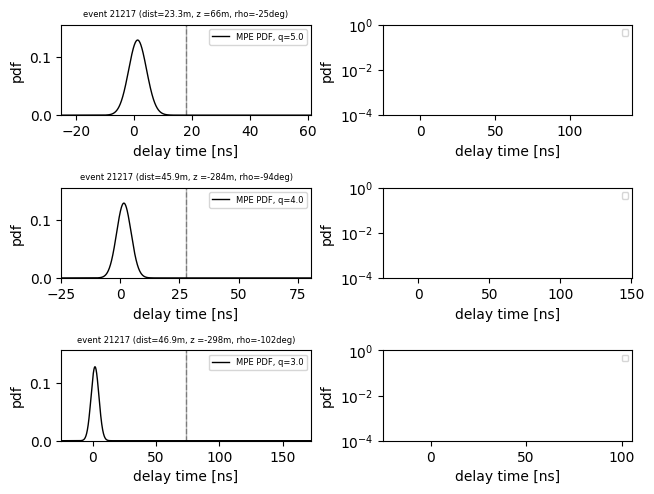

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


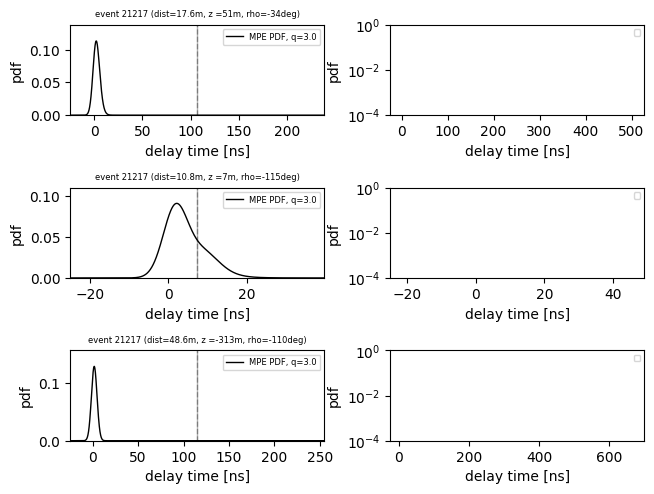

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6


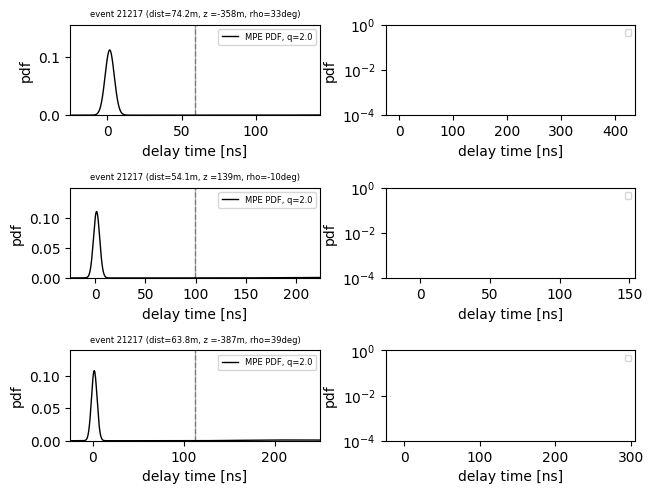

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9


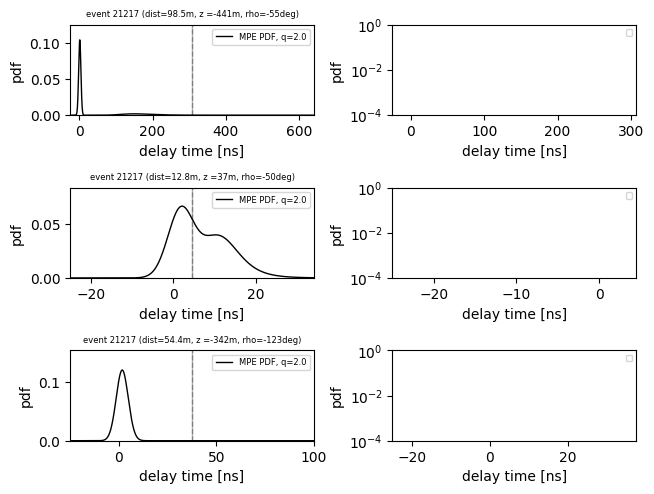

In [23]:
make_event_plot(event_start=0, event_end=1000, event_id=21217)